In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd

In [2]:
data=pd.read_csv(r"C:\Users\91798\Desktop\nw\data\DEEP LEARNING\datasets\spam.csv")

In [3]:
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
data['Category'].describe()

count     5572
unique       2
top        ham
freq      4825
Name: Category, dtype: object

In [5]:
data['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [6]:
747/4875

0.15323076923076923

# 15% spam emails, 85% ham emails: This indicates class imbalance 

In [7]:
data_spam = data[data['Category']=='spam']
data_spam.shape

(747, 2)

In [8]:
data_ham = data[data['Category']=='ham']
data_ham.shape

(4825, 2)

In [9]:
data_ham_downsampled = data_ham.sample(747)
data_ham_downsampled.shape

(747, 2)

In [10]:
data_balanced = pd.concat([data_ham_downsampled, data_spam])
data_balanced.shape

(1494, 2)

In [11]:
data_balanced['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [12]:
data_balanced.sample(10)

,Category,Message
1227,spam,Reply with your name and address and YOU WILL ...
4770,ham,watever reLation u built up in dis world only ...
1153,ham,Ok i go change also...
5493,ham,I think if he rule tamilnadu..then its very to...
455,spam,"Loan for any purpose £500 - £75,000. Homeowner..."
2295,spam,You have 1 new message. Please call 08718738034.
2653,ham,No need for the drug anymore.
731,spam,Email AlertFrom: Jeri StewartSize: 2KBSubject:...
4518,ham,"Men always needs a beautiful, intelligent, car..."
1347,ham,Is it ok if I stay the night here? Xavier has ...


In [13]:
data_balanced['spam']=data_balanced['Category'].apply(lambda z:1 if z=='spam' else 0)

In [14]:
data_balanced.sample(5)

,Category,Message,spam
1976,ham,Delhi and chennai still silent.,0
2548,spam,"Text82228>> Get more ringtones, logos and game...",1
3623,ham,Goin to workout lor... Muz lose e fats...,0
1456,spam,Summers finally here! Fancy a chat or flirt wi...,1
2865,ham,What I'm saying is if you haven't explicitly t...,0


In [15]:
from sklearn.model_selection import train_test_split

In [16]:
 X_train, X_test, y_train, y_test = train_test_split(data_balanced['Message'],data_balanced['spam'],stratify=data_balanced['spam'],test_size=0.25)

In [17]:
X_train


196                          Gud mrng dear hav a nice day
42      07732584351 - Rodger Burns - MSG = We tried to...
236     I have printed it oh. So  &lt;#&gt;  come upst...
2632    URGENT! Your mobile No 077xxx WON a £2,000 Bon...
499           Kate jackson rec center before 7ish, right?
                              ...                        
2784         Just arrived, see you in a couple days &lt;3
5228    PRIVATE! Your 2003 Account Statement for <fone...
2478    I'm done. I'm sorry. I hope your next space gi...
2813    Say this slowly.? GOD,I LOVE YOU &amp; I NEED ...
5203                              Me fine..absolutly fine
Name: Message, Length: 1120, dtype: object

# Applying  BERT classification

In [18]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [19]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.843517  , -0.5132726 , -0.8884572 , ..., -0.74748856,
        -0.7531473 ,  0.91964483],
       [-0.8720835 , -0.50543964, -0.94446677, ..., -0.8584752 ,
        -0.7174535 ,  0.8808299 ]], dtype=float32)>

In [20]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [21]:
e

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[-0.7606917 , -0.14219394,  0.4960459 , ...,  0.42165306,
        -0.5322142 ,  0.80312175],
       [-0.8602322 , -0.21242936,  0.49156928, ...,  0.39798063,
        -0.60506284,  0.8447163 ],
       [-0.7128859 , -0.15463904,  0.38401678, ...,  0.35278738,
        -0.50991327,  0.7347408 ],
       [-0.82533467, -0.35550585, -0.590697  , ..., -0.016137  ,
        -0.6141757 ,  0.872303  ],
       [-0.75041336, -0.2681263 , -0.26689744, ...,  0.02839341,
        -0.59381   ,  0.79749876],
       [-0.7854437 , -0.29949695,  0.4102739 , ...,  0.5222542 ,
        -0.4957355 ,  0.815075  ]], dtype=float32)>

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

In [23]:
cosine_similarity([e[0]],[e[3]])

array([[0.8470384]], dtype=float32)

In [24]:
cosine_similarity([e[3]],[e[4]])

array([[0.98720354]], dtype=float32)

In [30]:
# Bert Layers
text_input=tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
preprocessed_text = bert_preprocess(text_input)
output=bert_encoder(preprocessed_text)

# neural network layer

l = tf.keras.layers.Dropout(0.1, name="dropout")(output['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [32]:
len(X_train)

1120

In [33]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [36]:
model.fit(X_train,y_train,epochs=5)

Epoch 1/5
35/35 [==============================] - 294s 8s/step - loss: 0.4137 - accuracy: 0.8643 - precision: 0.8481 - recall: 0.8875
Epoch 2/5
35/35 [==============================] - 296s 8s/step - loss: 0.3751 - accuracy: 0.8714 - precision: 0.8636 - recall: 0.8821
Epoch 3/5
35/35 [==============================] - 748s 22s/step - loss: 0.3541 - accuracy: 0.8830 - precision: 0.8667 - recall: 0.9054
Epoch 4/5
35/35 [==============================] - 311s 9s/step - loss: 0.3233 - accuracy: 0.8964 - precision: 0.8841 - recall: 0.9125
Epoch 5/5
35/35 [==============================] - 306s 9s/step - loss: 0.3077 - accuracy: 0.8982 - precision: 0.8872 - recall: 0.9125


In [38]:
model.evaluate(X_test,y_test)

12/12 [==============================] - 102s 8s/step - loss: 0.3262 - accuracy: 0.8877 - precision: 0.8341 - recall: 0.9679


[0.32624706625938416,
 0.8877005577087402,
 0.8341013789176941,
 0.9679144620895386]

In [39]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 105s 9s/step


In [40]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,

In [41]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[151,  36],
       [  6, 181]], dtype=int64)

Text(33.0, 0.5, 'Truth')

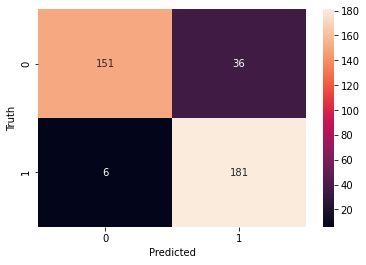

In [42]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [43]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.96      0.81      0.88       187
           1       0.83      0.97      0.90       187

    accuracy                           0.89       374
   macro avg       0.90      0.89      0.89       374
weighted avg       0.90      0.89      0.89       374



In [44]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]


In [45]:
model.predict(reviews)

1/1 [==============================] - 4s 4s/step


array([[0.7755106 ],
       [0.81712735],
       [0.7956157 ],
       [0.38204396],
       [0.19220988]], dtype=float32)